# Application of XGBoost: Exam score prediction

### Imports

In [2]:
# XGBoost pipeline for Kaggle "exam score" regression
# - loads /rds/rds-lxu/ml_datasets/exam_score_predict/train.csv and test.csv
# - one-hot encodes categorical columns
# - trains XGBoost (GPU)
# - evaluates on a validation split
# - fits on full train and writes submission.csv

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Load data

In [9]:
DATA_DIR = "/rds/rds-lxu/ml_datasets/exam_score_predict"
train_path = f"{DATA_DIR}/train.csv"
test_path  = f"{DATA_DIR}/test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("train:", train_df.shape, "test:", test_df.shape)
print("train columns:", list(train_df.columns))
print("test columns :", list(test_df.columns))

TARGET = "exam_score"
ID_COL = "id"

y = train_df[TARGET].astype(float).values
X_train_raw = train_df.drop(columns=[TARGET])
X_test_raw  = test_df.copy()
print("Initial train shape:", X_train_raw.shape, "test shape:", X_test_raw.shape)

train: (630000, 13) test: (270000, 12)
train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']
test columns : ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Initial train shape: (630000, 12) test shape: (270000, 12)


### Clean training data

In [13]:
# --- Basic cleaning (optional but safe) ---
# Ensure consistent types
for c in X_train_raw.columns:
    if X_train_raw[c].dtype == "object":
        X_train_raw[c] = X_train_raw[c].astype(str)
        X_test_raw[c]  = X_test_raw[c].astype(str)
        # print(f"Column {c} is categorical/string")

# Fill missing (if any)
X_train_raw = X_train_raw.fillna("missing")
X_test_raw  = X_test_raw.fillna("missing")
print("After cleaning, train:", X_train_raw.shape, "test:", X_test_raw.shape)   

After cleaning, train: (630000, 12) test: (270000, 12)


### One-hot encoding

In [17]:
# --- One-hot encode categoricals (train+test together to align columns) ---
all_X = pd.concat([X_train_raw, X_test_raw], axis=0, ignore_index=True)
# print("Combined data shape for encoding:", all_X.shape)
all_X_enc = pd.get_dummies(all_X, columns=all_X.select_dtypes(include=["object"]).columns, drop_first=False)

X_train = all_X_enc.iloc[:len(X_train_raw)].values
X_test  = all_X_enc.iloc[len(X_train_raw):].values

feature_names = list(all_X_enc.columns)
print("Encoded feature dim:", X_train.shape[1])

Encoded feature dim: 31


### Train

In [19]:

# --- Train/valid split for diagnostics ---
X_tr, X_va, y_tr, y_va = train_test_split(
    X_train, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=3000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,

    # GPU (new style)
    tree_method="hist",
    device="cuda:0",

    reg_lambda=1.0,
    reg_alpha=0.0,

    objective="reg:squarederror",
    eval_metric="rmse",
    early_stopping_rounds=100,   # NOTE: for your version, must be in constructor
    verbosity=2,
)

model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=50
)

[18:56:01] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (504000, 31, 15624000).
[18:56:01] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (126000, 31, 3906000).
[18:56:01] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
[18:56:01] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
[0]	validation_0-rmse:18.47513
[50]	validation_0-rmse:10.12677
[100]	validation_0-rmse:8.92864
[150]	validation_0-rmse:8.79946
[200]	validation_0-rmse:8.77719
[250]	validation_0-rmse:8.76980
[300]	validation_0-rmse:8.76558
[350]	validation_0-rmse:8.76204
[400]	validation_0-rmse:8.75963
[450]	validation_0-rmse:8.75770
[500]	validation_0-rmse:8.75516
[550]	validation_0-rmse:8.75332
[600]	validation_0-rmse:8.75201
[650]	validation_0-rmse:8.75103
[700]	validation_0-rmse:8.75007
[750]	validation_0-rmse:8.74939
[800]	validation_0-rmse:8.74909
[850]	validation_0-rmse:8.74905
[900]	vali

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda:0'
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'rmse'


### Inference

In [20]:
# --- Validation metrics ---
y_va_pred = model.predict(X_va)
rmse = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
mae  = float(mean_absolute_error(y_va, y_va_pred))
r2   = float(r2_score(y_va, y_va_pred))

print("\n=== Validation metrics ===")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R^2 : {r2:.6f}")
print("Best iteration:", model.best_iteration)
print("Best score:", model.best_score)


=== Validation metrics ===
RMSE: 8.748654
MAE : 6.973116
R^2 : 0.784790
Best iteration: 909
Best score: 8.748654062653378


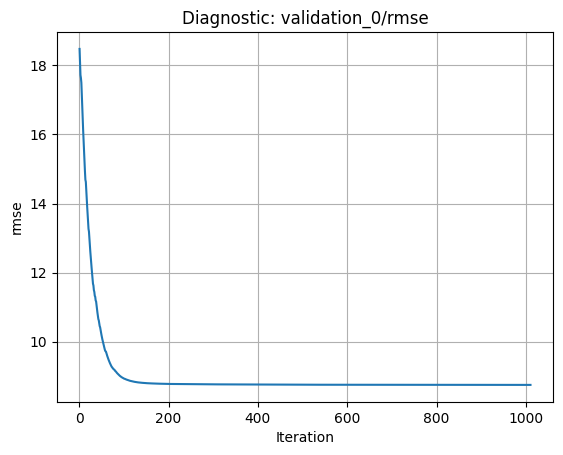

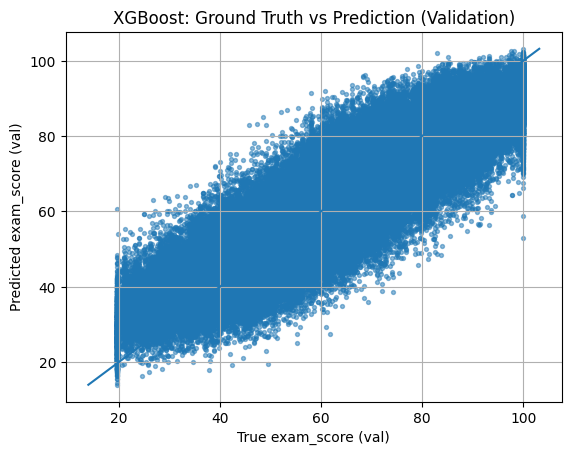

In [21]:
# --- Plot training diagnostic metric ---
res = model.evals_result()
ds0 = next(iter(res.keys()))                 # typically "validation_0"
metric0 = next(iter(res[ds0].keys()))        # e.g. "rmse"
vals = np.asarray(res[ds0][metric0], dtype=float)

plt.figure()
plt.plot(np.arange(1, len(vals) + 1), vals)
plt.xlabel("Iteration")
plt.ylabel(metric0)
plt.title(f"Diagnostic: {ds0}/{metric0}")
plt.grid(True)
plt.show()

# --- Plot truth vs prediction on validation ---
plt.figure()
plt.scatter(y_va, y_va_pred, s=8, alpha=0.5)
mn = float(min(y_va.min(), y_va_pred.min()))
mx = float(max(y_va.max(), y_va_pred.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True exam_score (val)")
plt.ylabel("Predicted exam_score (val)")
plt.title("XGBoost: Ground Truth vs Prediction (Validation)")
plt.grid(True)
plt.show()

In [22]:
# --- Refit on full training data using best_iteration ---
best_n = int(model.best_iteration) + 1

final_model = XGBRegressor(
    n_estimators=best_n,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="cuda:0",
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="reg:squarederror",
    verbosity=1,
)

final_model.fit(X_train, y)

# --- Predict test and write submission ---
test_pred = final_model.predict(X_test)

sub = pd.DataFrame({
    ID_COL: test_df[ID_COL].values,
    TARGET: test_pred
})

out_path = f"{DATA_DIR}/submission.csv"
sub.to_csv(out_path, index=False)

print("\nWrote:", out_path)
print(sub.head())



Wrote: /rds/rds-lxu/ml_datasets/exam_score_predict/submission.csv
       id  exam_score
0  630000   70.769791
1  630001   69.753555
2  630002   85.768021
3  630003   57.853191
4  630004   46.917744
